# Goal

This notebook tries to investigate the possible difference between the models' use and training.
e.g. Is the model used in inference on the same window size as it was trained on?

This notebook also investigates how the data is used and how the dataset is created. Does it contain any bias/ unbalance etc...

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image

import rosbag

from params import PROJECT_PATH
import params.robot

Failed to load Python extension for LZ4 support. LZ4 compression will not be available.


# Costs inputted in vision-based learning?
Costs used in the training of the vision based models seem to follow the same distribution as the one learned by the siamese model.
The features inputted to the siamese model in training and inference are hence probably the same.
This is therefore not the sourced of the low performance.

In [4]:
inference_cost_csv = (
    PROJECT_PATH
    / "datasets/dataset_multimodal_siamese_png_filtered_hard/traversal_costs_train.csv"
)

inference_cost_df = pd.read_csv(inference_cost_csv)
inference_cost_df

,image_id,traversal_cost,traversability_label,linear_velocity
0,1075,1.763922,2,1.045353
1,2964,2.611441,4,0.968544
2,3287,2.909468,4,0.992342
3,2498,2.553961,4,0.948633
4,4517,3.215345,5,1.039666
...,...,...,...,...
4090,3499,4.438968,8,0.989194
4091,2880,3.553759,6,0.989471
4092,1034,1.773461,2,1.081694
4093,1071,1.766719,2,1.086732


In [5]:
train_cost_csv = (
    PROJECT_PATH
    / "src/traversal_cost/siamese_network/logs/_2023-09-27-12-22-04/costs_df.csv"
)

train_cost_df = pd.read_csv(train_cost_csv)
train_cost_df

,Unnamed: 0,terrain_class,linear_velocity,cost
0,0,grass_easy,0.2,2.332287
1,1,grass_easy,0.2,2.295089
2,2,grass_easy,0.2,2.279682
3,3,grass_easy,0.2,2.335167
4,4,grass_easy,0.2,2.312038
...,...,...,...,...
1255,1255,sand_hard,1.0,2.804955
1256,1256,sand_hard,1.0,4.190214
1257,1257,sand_hard,1.0,4.353060
1258,1258,sand_hard,1.0,3.190498


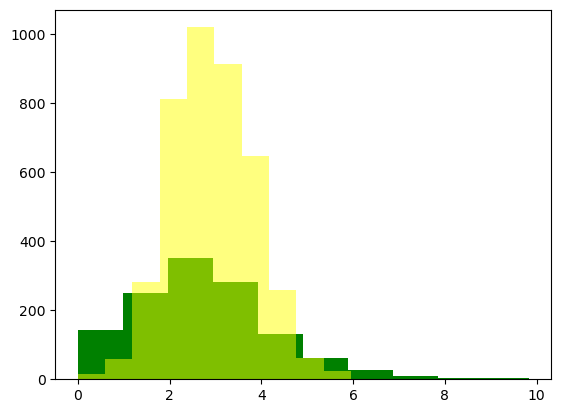

In [6]:
plt.hist(train_cost_df["cost"], bins=10, color="green")
plt.hist(inference_cost_df["traversal_cost"], color="yellow", alpha=0.5)

# Images inputted to the vision model
- Not enough data (< 200 images)
- Gravel and road image patches are hard to distinguish => need bigger patch to include more context

# Which resolutions for patches?
A minimum width of 200 pixels seems a good trade-off to keep a minimum understandable resolution.

In [3]:
def plot_width_distribution(dataset):
    image_dir = PROJECT_PATH / f"datasets/dataset_{dataset}" / "images"
    # XXX: PIL's dimension has (width, height) order
    image_width = [
        Image.open(image_dir / image_name).size[0]
        for image_name in image_dir.glob("*[!nd].png")
    ]

    plt.hist(image_width, bins=30)

    plt.title(f"Image width distribution of\n{dataset}")
    plt.xlabel("Width")
    plt.ylabel("Nb images")

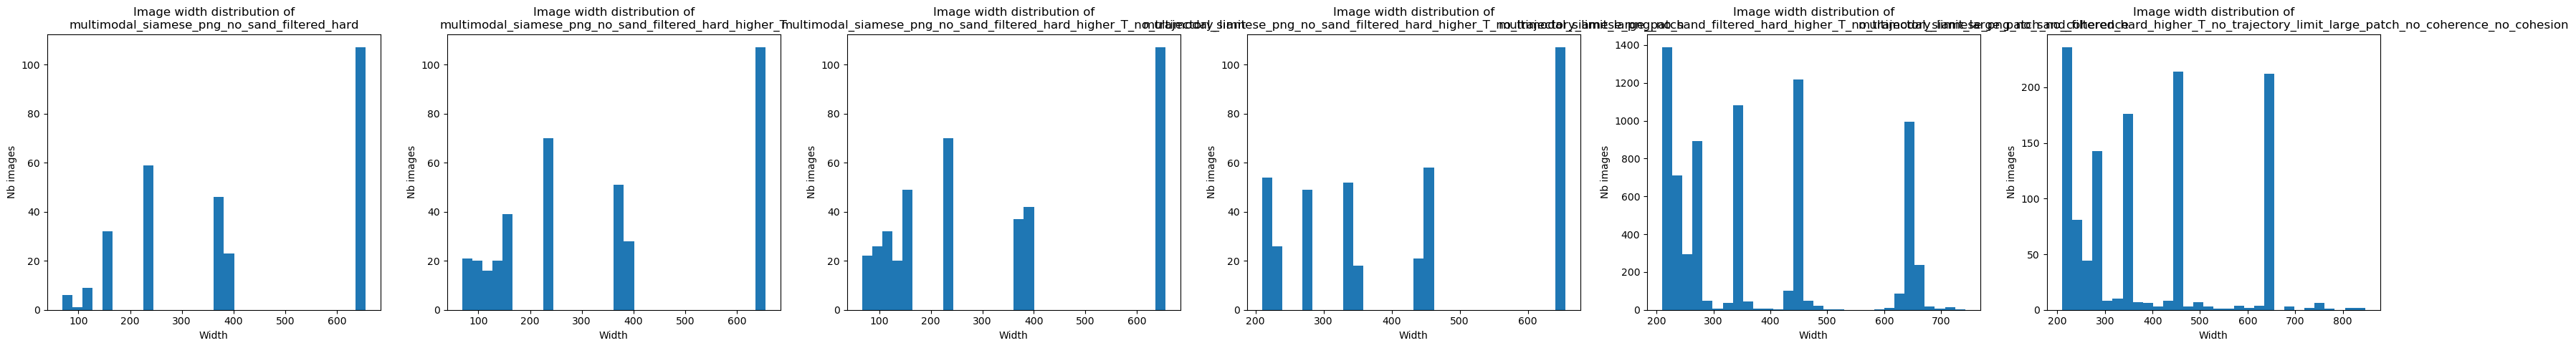

In [4]:
DATASET_LIST = [
    "multimodal_siamese_png_no_sand_filtered_hard",
    "multimodal_siamese_png_no_sand_filtered_hard_higher_T",
    "multimodal_siamese_png_no_sand_filtered_hard_higher_T_no_trajectory_limit",
    "multimodal_siamese_png_no_sand_filtered_hard_higher_T_no_trajectory_limit_large_patch",
    "multimodal_siamese_png_no_sand_filtered_hard_higher_T_no_trajectory_limit_large_patch_no_coherence",
    "multimodal_siamese_png_no_sand_filtered_hard_higher_T_no_trajectory_limit_large_patch_no_coherence_no_cohesion",
]


def plot_for_all_dataset(plot_fct):
    plt.figure(figsize=(7 * len(DATASET_LIST), 5))
    for i, dataset in enumerate(DATASET_LIST, start=1):
        plt.subplot(1, len(DATASET_LIST), i)
        plot_fct(dataset)


plot_for_all_dataset(plot_width_distribution)

# What does the IMU space look like?
The features seems relevant. From the plot bellow, the regression cost seems to fluently follow the main component.
But is using a NN for this task really necessary?

In [ ]:
feature_dir = (
    PROJECT_PATH / "src/traversal_cost/datasets/dataset_200Hz_wrap_fft/features"
)
cost_file = (
    PROJECT_PATH
    / "src/traversal_cost/siamese_network/logs/_2023-09-27-12-22-04/costs_df.csv"
)

cost_df = pd.read_csv(cost_file, index_col=0)
cost_df = cost_df[~cost_df["terrain_class"].isin(["sand_hard", "sand_medium"])]
cost_df

,terrain_class,linear_velocity,cost
0,grass_easy,0.2,2.332287
1,grass_easy,0.2,2.295089
2,grass_easy,0.2,2.279682
3,grass_easy,0.2,2.335167
4,grass_easy,0.2,2.312038
...,...,...,...
955,forest_leaves,1.0,3.497359
956,forest_leaves,1.0,3.391089
957,forest_leaves,1.0,3.635105
958,forest_leaves,1.0,3.519783


In [ ]:
def get_features(row: pd.Series) -> np.ndarray:
    features = np.load(feature_dir / f"{row.name:03}.npy")
    return features


cost_df["IMU features"] = cost_df.apply(get_features, axis=1)
cost_df

,terrain_class,linear_velocity,cost,IMU features
0,grass_easy,0.2,2.332287,"[3.256301165627901, 2.0849204320223884, 0.4560..."
1,grass_easy,0.2,2.295089,"[1.8148938037860471, 1.0233097706037686, 0.213..."
2,grass_easy,0.2,2.279682,"[0.4294608088828442, 0.30374210080107494, 0.49..."
3,grass_easy,0.2,2.335167,"[2.5484633707508495, 1.0269815078945463, 0.383..."
4,grass_easy,0.2,2.312038,"[0.4775256695705397, 0.3397432059309903, 0.072..."
...,...,...,...,...
955,forest_leaves,1.0,3.497359,"[0.6016500689520513, 0.9963473753447926, 0.955..."
956,forest_leaves,1.0,3.391089,"[1.9792491282933482, 1.5889099228880939, 0.896..."
957,forest_leaves,1.0,3.635105,"[1.1883941923119288, 1.6142182401573928, 1.550..."
958,forest_leaves,1.0,3.519783,"[0.9379748852317534, 1.2466072359375384, 1.156..."


In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
# perform dimension reduction with pca
pca.fit(np.stack(cost_df["IMU features"].values))
# transform the features
reduced_features = pca.transform(np.stack(cost_df["IMU features"].values))
reduced_features.shape

(960, 3)

In [ ]:
pca.explained_variance_ratio_

array([0.77548032, 0.12085436, 0.05124565])

In [ ]:
import plotly.express as px

fig = px.scatter_3d(
    reduced_features,
    x=0,
    y=1,
    z=2,
    # color=cost_df["terrain_class"],
    color=cost_df["cost"],
    title="PCA of IMU features",
    labels={"0": "PC1", "1": "PC2", "2": "PC3"},
)
fig.show()

# Velocity Representation in vision dataset
Need to balance more images. 0.6m/s is overrepresented, while 0.2 is clearly underrepresented.

In [53]:
VELOCITY_VALUES = [0.2, 0.4, 0.6, 0.8, 1]


def group_by_velocity(cost_df: pd.DataFrame) -> pd.DataFrame:
    return cost_df["linear_velocity"].apply(
        lambda x: min(VELOCITY_VALUES, key=lambda v: abs(v - x))
    )

In [60]:
def plot_velocity_representation(cost_df: pd.DataFrame):
    cost_df["velocity_group"] = group_by_velocity(cost_df)
    samples_per_velocity = (
        cost_df[["velocity_group", "traversal_cost"]]
        .groupby("velocity_group")
        .count()
        .values.flatten()
    )
    plt.bar(VELOCITY_VALUES, samples_per_velocity, width=0.1)
    plt.xlabel("Velocity")
    plt.ylabel("Number of samples")

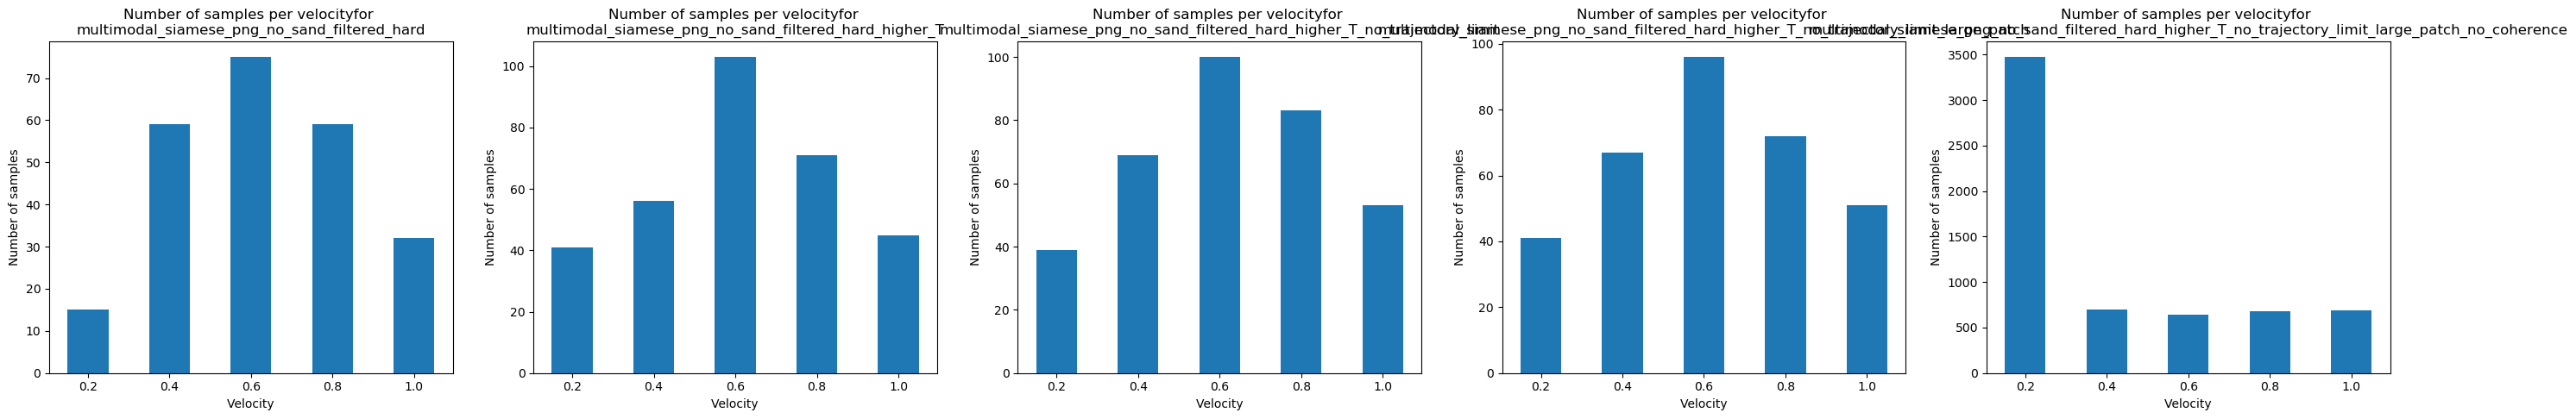

In [61]:
def tmp_plot(dataset: str):
    DATASET = PROJECT_PATH / f"datasets/dataset_{dataset}"
    train_csv = DATASET / "traversal_costs_train.csv"

    cost_df = pd.read_csv(train_csv)

    plot_velocity_representation(cost_df)
    plt.title(f"Number of samples per velocityfor \n{dataset}")


plot_for_all_dataset(tmp_plot)

# Cost distribution mismatch between ground truth and prediction of the vision model
Predictions based exclusively on the velocity. Not enough images for the CNN to learn? Or need to change the model?

In [55]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader

import params.visualparams
import params.learning
from params import PROJECT_PATH

from dataset import TraversabilityDataset

LEARNING_PARAMS = params.learning.LEARNING
NORMALIZE_PARAMS = params.learning.NORMALIZE_PARAMS


def get_model(dataset):
    model = params.visualparams.MODEL
    WEIGHTS = (
        PROJECT_PATH
        / f"src/models_development/multimodal_velocity_regression_alt/logs/_{dataset}/network.params"
    )
    model.load_state_dict(torch.load(WEIGHTS))
    model.eval()
    return model


def get_dataloader(dataset):
    DATASET = PROJECT_PATH / f"datasets/dataset_{dataset}"

    # Define a different set of transforms testing
    # (for instance we do not need to flip the image)
    test_transform = transforms.Compose(
        [
            # transforms.Resize(100),
            transforms.Resize(params.learning.IMAGE_SHAPE, antialias=True),
            # transforms.Grayscale(),
            # transforms.CenterCrop(100),
            # transforms.RandomCrop(100),
            transforms.ToTensor(),
            # Mean and standard deviation were pre-computed on the training data
            # (on the ImageNet dataset)
            transforms.Normalize(
                mean=NORMALIZE_PARAMS["rbg"]["mean"], std=NORMALIZE_PARAMS["rbg"]["std"]
            ),
        ]
    )

    transform_depth = transforms.Compose(
        [
            # Convert a PIL Image or numpy.ndarray to tensor
            transforms.ToTensor(),
            # Reduce the size of the images
            # (if size is an int, the smaller edge of the
            # image will be matched to this number and the ration is kept)
            transforms.Resize(params.learning.IMAGE_SHAPE, antialias=True),
            # Normalize a tensor image with pre-computed mean and standard deviation
            # (based on the data used to train the model(s))
            # (be careful, it only works on torch.*Tensor)
            transforms.Normalize(
                mean=NORMALIZE_PARAMS["depth"]["mean"],
                std=NORMALIZE_PARAMS["depth"]["std"],
            ),
        ]
    )

    transform_normal = transforms.Compose(
        [
            # Convert a PIL Image or numpy.ndarray to tensor
            transforms.ToTensor(),
            # Reduce the size of the images
            # (if size is an int, the smaller edge of the
            # image will be matched to this number and the ration is kept)
            transforms.Resize(params.learning.IMAGE_SHAPE, antialias=True),
            # Normalize a tensor image with pre-computed mean and standard deviation
            # (based on the data used to train the model(s))
            # (be careful, it only works on torch.*Tensor)
            transforms.Normalize(
                mean=NORMALIZE_PARAMS["normal"]["mean"],
                std=NORMALIZE_PARAMS["normal"]["std"],
            ),
        ]
    )

    test_set = TraversabilityDataset(
        traversal_costs_file=DATASET / "traversal_costs_test.csv",
        images_directory=DATASET / "images_test",
        transform_image=test_transform,
        transform_depth=transform_depth,
        transform_normal=transform_normal,
    )

    test_loader = DataLoader(
        test_set,
        batch_size=LEARNING_PARAMS["batch_size"],
        shuffle=False,  # SequentialSampler
        num_workers=12,
        pin_memory=True,
    )
    return test_loader

In [56]:
def get_cost_df(model, test_loader, *, device="cuda"):
    cost_df = pd.DataFrame(
        columns=["linear_velocity", "traversal_cost", "predicted_traversal_cost"]
    )

    for images, traversal_costs, linear_velocities in test_loader:
        images = images.to(device)
        traversal_costs = traversal_costs.to(device)
        linear_velocities = linear_velocities.type(torch.float32).to(device)

        # Add a dimension to the linear velocities tensor
        linear_velocities.unsqueeze_(1)
        predicted_traversability_cost = model(images, linear_velocities)

        tmp_df = pd.DataFrame(
            {
                "linear_velocity": linear_velocities.cpu().detach().numpy().flatten(),
                "traversal_cost": traversal_costs.cpu().detach().numpy().flatten(),
                "predicted_traversal_cost": predicted_traversability_cost.cpu()
                .detach()
                .numpy()
                .flatten(),
            }
        )
        cost_df = pd.concat([cost_df, tmp_df], ignore_index=True)

    return cost_df

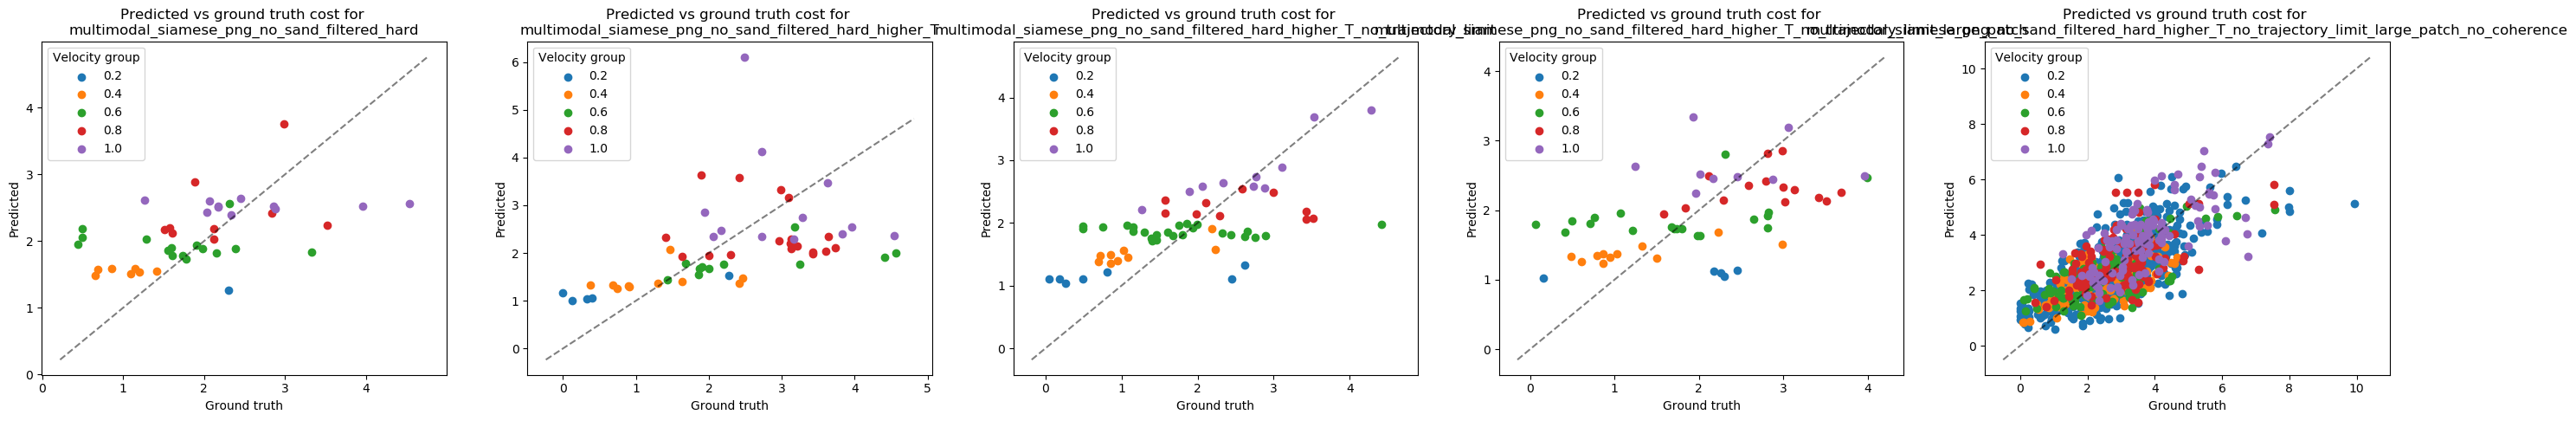

In [57]:
def plot_pred_vs_gt_cost(cost_df):
    cost_df["velocity_group"] = group_by_velocity(cost_df)

    for group, data in cost_df.groupby("velocity_group"):
        plt.scatter(
            data["traversal_cost"], data["predicted_traversal_cost"], label=group
        )

    plt.plot(plt.xlim(), plt.xlim(), color="black", linestyle="--", alpha=0.5)

    plt.xlabel("Ground truth")
    plt.ylabel("Predicted")
    plt.legend(title="Velocity group")


def tmp_plot(dataset: str):
    model = get_model(dataset)
    test_loader = get_dataloader(dataset)

    cost_df = get_cost_df(model, test_loader)
    plot_pred_vs_gt_cost(cost_df)
    plt.title(f"Predicted vs ground truth cost for \n{dataset}")


plot_for_all_dataset(tmp_plot)

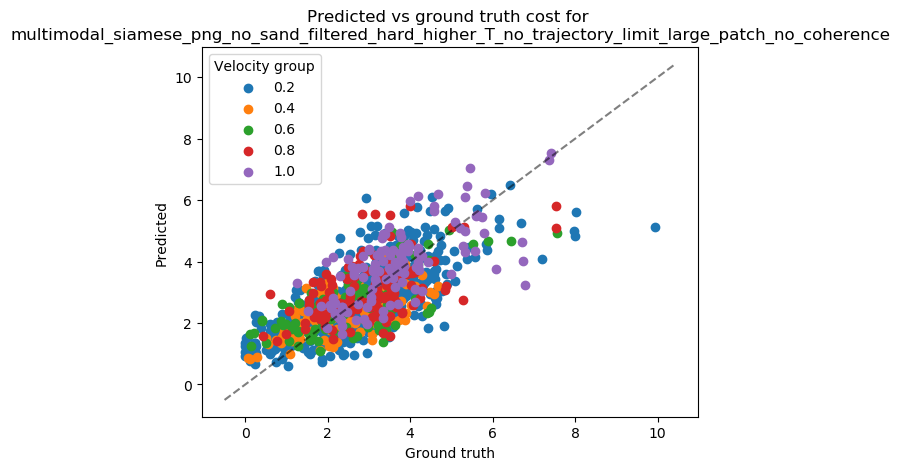

In [58]:
tmp_plot(DATASET_LIST[-1])

# Why vision-based datasets are so small?

## Why is the "Terrain_samples" and "road_grass" datasets almost of the same size?
Terrain_samples should have x2 or x3 more data.

### Recode src/data_preparation/create_dataset.py to understand filters

In [2]:
files = [
    "bagfiles/raw_bagfiles/Terrains_Samples/dust.bag",
    "bagfiles/raw_bagfiles/Terrains_Samples/forest_dirt_easy.bag",
    "bagfiles/raw_bagfiles/Terrains_Samples/forest_dirt_medium.bag",
    "bagfiles/raw_bagfiles/Terrains_Samples/forest_dirt_stones_branches.bag",
    "bagfiles/raw_bagfiles/Terrains_Samples/forest_leaves.bag",
    "bagfiles/raw_bagfiles/Terrains_Samples/forest_leaves_branches.bag",
    "bagfiles/raw_bagfiles/Terrains_Samples/grass_easy.bag",
    "bagfiles/raw_bagfiles/Terrains_Samples/grass_medium.bag",
    "bagfiles/raw_bagfiles/Terrains_Samples/gravel_easy.bag",
    "bagfiles/raw_bagfiles/Terrains_Samples/gravel_medium.bag",
    "bagfiles/raw_bagfiles/Terrains_Samples/road_easy.bag",
    "bagfiles/raw_bagfiles/Terrains_Samples/road_medium.bag",
]

#### How many images at the beginning?

In [ ]:
def count_images(file: str) -> int:
    bag = rosbag.Bag(str(PROJECT_PATH / file))
    return bag.get_message_count(params.robot.IMAGE_TOPIC)


list(map(count_images, files))

[466, 504, 497, 483, 476, 491, 481, 476, 489, 483, 482, 471]

In [ ]:
sum(map(count_images, files))

5799

#### Images per terrain class

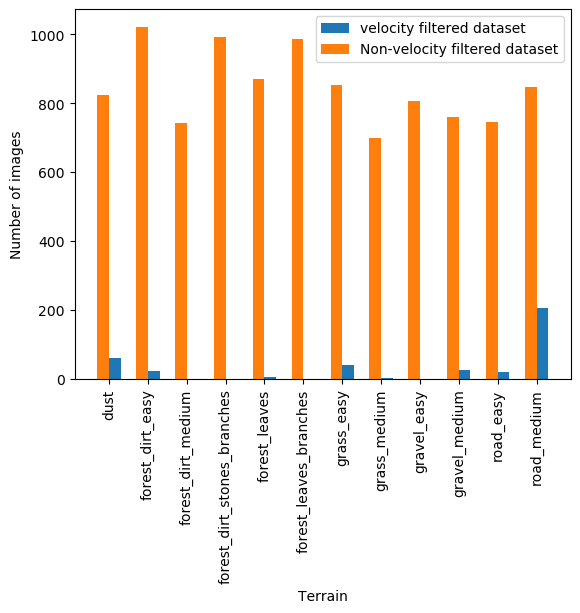

In [7]:
# Values computed by hand, by printing in "src/data_preparation/create_dataset.py:DatasetBuilder.write_images_and_compute_features()"
velocity_filter_nb_images = {
    "dust": 60,
    "forest_dirt_easy": 24,
    "forest_dirt_medium": 0,
    "forest_dirt_stones_branches": 0,
    "forest_leaves": 4,
    "forest_leaves_branches": 0,
    "grass_easy": 41,
    "grass_medium": 3,
    "gravel_easy": 0,
    "gravel_medium": 26,
    "road_easy": 20,
    "road_medium": 207,
}

# i.e. without coherence filtering
non_velocity_filter_nb_images = {
    "dust": 824,
    "forest_dirt_easy": 1022,
    "forest_dirt_medium": 742,
    "forest_dirt_stones_branches": 993,
    "forest_leaves": 872,
    "forest_leaves_branches": 987,
    "grass_easy": 854,
    "grass_medium": 698,
    "gravel_easy": 806,
    "gravel_medium": 760,
    "road_easy": 747,
    "road_medium": 846,
}

# bar plot of the number of images per terrain
plt.bar(
    range(len(velocity_filter_nb_images)),
    velocity_filter_nb_images.values(),
    width=0.3,
    align="edge",
    label="velocity filtered dataset",
)
plt.bar(
    range(len(non_velocity_filter_nb_images)),
    non_velocity_filter_nb_images.values(),
    width=-0.3,
    align="edge",
    label="Non-velocity filtered dataset",
)
plt.xticks(
    range(len(velocity_filter_nb_images)),
    velocity_filter_nb_images.keys(),
    rotation=90,
)
plt.xlabel("Terrain")
plt.ylabel("Number of images")
plt.legend()

#### Bag healthiness check
Does not remove any bag from "terrain_samples".

In [ ]:
import params.dataset


def is_bag_healthy(file: str) -> bool:
    """Check if a bag file is healthy

    Args:
        file (str): Path to the bag file

    Returns:
        bool: True if the bag file is healthy, False otherwise
    """
    bag = rosbag.Bag(str(PROJECT_PATH / file))
    duration = bag.get_end_time() - bag.get_start_time()  # [seconds]

    for topic, frequency in [
        (params.robot.IMAGE_TOPIC, params.robot.CAMERA_SAMPLE_RATE),
        (params.robot.DEPTH_TOPIC, params.robot.DEPTH_SAMPLE_RATE),
        (params.robot.ODOM_TOPIC, params.robot.ODOM_SAMPLE_RATE),
        (params.robot.IMU_TOPIC, params.robot.IMU_SAMPLE_RATE),
    ]:
        # Get the number of messages in the bag file
        nb_messages = bag.get_message_count(topic)

        # Check if the number of messages is consistent with the frequency
        if (
            np.abs(nb_messages - frequency * duration) / (frequency * duration)
            > params.dataset.NB_MESSAGES_THR
        ):
            return False

    return True


list(map(is_bag_healthy, files))

[True, True, True, True, True, True, True, True, True, True, True, True]

#### Depth match filter
Seems relevant. And only removes 20% or so of the data.

In [ ]:
from tqdm import tqdm

from functools import lru_cache


def get_content_closure(topic: str):
    def get_content(file: str):
        """
        Extract images from a bag file
        """
        bag = rosbag.Bag(str(PROJECT_PATH / file))
        return bag, bag.read_messages(topics=[topic])

    return get_content


images_file_list = tqdm(
    map(get_content_closure(params.robot.IMAGE_TOPIC), files), total=len(files)
)

depths_file_list = tqdm(
    map(get_content_closure(params.robot.DEPTH_TOPIC), files), total=len(files)
)

  0%|          | 0/12 [00:00<?, ?it/s]

In [ ]:
import rospy

import itertools


def is_depth_matched(msg, bag) -> bool:
    _, __, time = msg

    return (
        list(
            bag.read_messages(
                topics=[params.robot.DEPTH_TOPIC],
                start_time=time - rospy.Duration(params.dataset.TIME_DELTA),
                end_time=time + rospy.Duration(params.dataset.TIME_DELTA),
            )
        )
        != []
    )


images_file_list, images_file_list_copy = itertools.tee(images_file_list)
depth_filter_images = itertools.starmap(
    lambda bag, images: filter(lambda msg: is_depth_matched(msg, bag), images),
    images_file_list_copy,
)

In [ ]:
@lru_cache
def count_image(iterable) -> int:
    return len(list(iterable))


depth_filter_images, iter_count = itertools.tee(depth_filter_images)

# Ok we loose 20% of the images here, but that's fine
list(map(count_image, iter_count))

100%|██████████| 12/12 [00:57<00:00,  4.81s/it]


[429, 428, 422, 418, 422, 419, 412, 351, 381, 384, 374, 434]

In [ ]:
depth_filter_images, iter_count = itertools.tee(depth_filter_images)
sum(map(count_image, iter_count))

4874

In [ ]:
def count_depths(file: str) -> int:
    bag = rosbag.Bag(str(PROJECT_PATH / file))
    return bag.get_message_count(params.robot.DEPTH_TOPIC)


# There is as many depths as images. So the filter on depth is not correct.
list(map(count_depths, files))

[466, 504, 497, 483, 476, 491, 481, 476, 489, 483, 482, 471]

In [ ]:
def get_timestamp(msg):
    _, __, time = msg
    return time.to_sec()


# XXX: There is a bug here for now: need to rerun cell defining images_file_list
images_file_list, images_file_list_copy = itertools.tee(images_file_list)
images_timestamps = itertools.starmap(
    lambda _, images: map(get_timestamp, images), images_file_list_copy
)

In [ ]:
images_timestamps, iter_count = itertools.tee(images_timestamps)
images_timestamps_list = list(map(list, iter_count))
images_timestamps_list

[[], [], [], [], [], [], [], [], [], [], [], []]

In [ ]:
depths_timestamps = itertools.starmap(
    lambda bag, depths: map(get_timestamp, depths), depths_file_list
)

In [ ]:
depths_timestamps, iter_count = itertools.tee(depths_timestamps)
depths_timestamps_list = list(map(list, iter_count))
depths_timestamps_list

100%|██████████| 12/12 [01:28<00:00,  7.41s/it]


[[1685445787.4866703,
  1685445798.0887895,
  1685445798.424487,
  1685445798.7272491,
  1685445799.0618832,
  1685445799.397077,
  1685445799.7130222,
  1685445800.0379124,
  1685445800.371494,
  1685445800.7189596,
  1685445801.037583,
  1685445801.3862486,
  1685445801.7054148,
  1685445802.0392516,
  1685445802.3928914,
  1685445802.7112708,
  1685445803.0479832,
  1685445803.3813717,
  1685445803.7253296,
  1685445804.0471869,
  1685445804.382009,
  1685445804.7065368,
  1685445805.0602806,
  1685445805.3698692,
  1685445805.7198243,
  1685445806.0439687,
  1685445806.391973,
  1685445806.700385,
  1685445807.0389726,
  1685445807.370356,
  1685445807.7295275,
  1685445808.0365968,
  1685445808.3681316,
  1685445808.7001617,
  1685445809.0712616,
  1685445809.3650422,
  1685445809.7296858,
  1685445810.0402462,
  1685445810.3702965,
  1685445810.7066398,
  1685445811.0485475,
  1685445811.3669462,
  1685445811.712862,
  1685445812.0375435,
  1685445812.365691,
  1685445812.699354,

In [ ]:
depths_timestamps_list[0][-1] - depths_timestamps_list[0][0]

166.23482871055603

In [16]:
# Most images are not matched with a depth
import plotly.express as px

images = np.array(images_timestamps_list[0])
depths = np.array(depths_timestamps_list[0])

mismatch = images - depths
plt.hist(mismatch, bins=100)
plt.axvline(x=params.dataset.TIME_DELTA, color="r", linestyle="--")
plt.axvline(x=-params.dataset.TIME_DELTA, color="r", linestyle="--")
plt.title("Histogram of the time difference between images and depths")

NameError: name 'images_timestamps_list' is not defined

#### Rover's speed filter
Threshold seems relevant. But, as is, filter out the image when going backward.
Being more flexible on the threshold could x2 the dataset size

##### Non-null velocity filter

In [ ]:
def is_velocity_positive(msg, bag) -> bool:
    _, _, time = msg
    _, first_msg_odom, _ = next(
        iter(bag.read_messages(topics=[params.robot.ODOM_TOPIC], start_time=time))
    )

    return first_msg_odom.twist.twist.linear.x >= params.dataset.LINEAR_VELOCITY_THR


# XXX: There is a bug here for now: need to rerun cell defining images_file_list
images_file_list, images_file_list_copy = itertools.tee(images_file_list)
velocity_filtered_images = itertools.starmap(
    lambda bag, images: filter(lambda msg: is_velocity_positive(msg, bag), images),
    images_file_list_copy,
)

In [ ]:
velocity_filtered_images, iter_count = itertools.tee(velocity_filtered_images)
list(map(count_image, iter_count))

100%|██████████| 12/12 [01:17<00:00,  6.42s/it]


[167, 252, 239, 257, 182, 201, 180, 198, 203, 183, 176, 168]

In [ ]:
velocity_filtered_images, iter_count = itertools.tee(velocity_filtered_images)
sum(map(count_image, iter_count))

2406

In [10]:
# Can the velocity be negative? e.g. when the robot is going backward?
# Is so this data would be filtered out, while we have IMU signal for it (that can be used).
# => Would allow a x2 on the dataset size.

import plotly.express as px

for file in np.array(files)[[1, 2, 3, 7, 8, 10]]:
    first_bag = rosbag.Bag(str(PROJECT_PATH / file))
    accelerations = [
        msg.linear_acceleration.x
        # msg.twist.twist.linear.x
        for _, msg, _ in first_bag.read_messages(topics=["/imu/data"])
    ]
    velocities = [
        msg.twist.twist.linear.x
        for _, msg, _ in first_bag.read_messages(topics=[params.robot.ODOM_TOPIC])
    ]

    fig = px.line(accelerations)
    fig.show()
    fig = px.line(velocities)
    fig.show()
    break

In [ ]:
sum(np.abs(np.array(velocities)) < params.dataset.LINEAR_VELOCITY_THR)

2210

##### Velocity coherence filter
Not so much relevant and filters out all the data.

##### Velocity cohesion filter
Does not filter much, but makes sense.